# init

In [1]:
import sys 
sys.path.append('pyfiles/')
import classes_loop as cl
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# for matrix import and display
import pandas as pd
from IPython.display import display_html 
import csv 

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

# points = cl.ellipse_example(numpts = 6)
# # note: 100 pts causes handling error

In [2]:
vin = cl.vineyard()
# re init these just to make sure we can run this multiple times
vin.pointset = np.empty(2)
vin.complexlist = []
vin.matrixlist = []
vin.keypointlist = []
n = 6
# note: double check that there's not any issues where complex forgets associated matrix
vin.add_complex(cl.ellipse_example(numpts = n, display = False),(2,1))
vin.add_complex(cl.ellipse_example(numpts = n, display = False),(-2,1))

simplices labeled by initial val, not column:

emptyset-1 birthed a -1dim h class killed by v1
v0 birthed a 0dim h class killed by e0
v5 birthed a 0dim h class killed by e5
v2 birthed a 0dim h class killed by e1
v4 birthed a 0dim h class killed by e4
v3 birthed a 0dim h class killed by e2
e3 birthed an inf 1dim h class


birth : [-1, 0, 5, 2, 4, 3]
death : [1, 0, 5, 1, 4, 2]
classdim : [-1, 0, 0, 0, 0, 0]
b_simplex : ['emptyset', 'v', 'v', 'v', 'v', 'v']
d_simplex : ['v', 'e', 'e', 'e', 'e', 'e']
simplices labeled by initial val, not column:

emptyset-1 birthed a -1dim h class killed by v2
v3 birthed a 0dim h class killed by e2
v4 birthed a 0dim h class killed by e3
v1 birthed a 0dim h class killed by e1
v5 birthed a 0dim h class killed by e4
v0 birthed a 0dim h class killed by e0
e5 birthed an inf 1dim h class


birth : [-1, 3, 4, 1, 5, 0]
death : [2, 2, 3, 1, 4, 0]
classdim : [-1, 0, 0, 0, 0, 0]
b_simplex : ['emptyset', 'v', 'v', 'v', 'v', 'v']
d_simplex : ['v', 'e', 'e', 'e', 'e', '

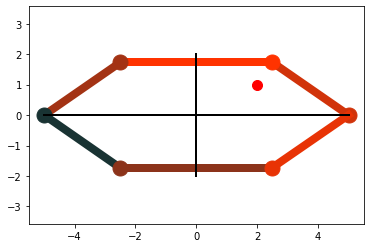

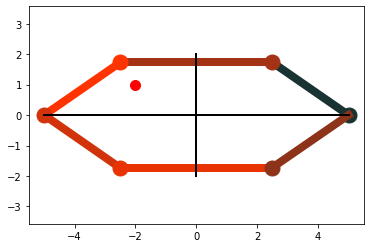

In [3]:
# not a bug: graph color seeming to either not update or have a wrong edge is due to 
# sparse sampling of input. Add 50 points to see that it captures distance properly.
vin.complexlist[0].plot(extras = False, label_edges = False, label_verts = False)
vin.complexlist[1].plot(extras = False, label_edges = False, label_verts = False)


In [7]:
# later we'll put this pair into a for loop in which we compare a lot of pairs
# maybe it would be nice to only ever store two complexes in a vineyard? Or do we need more? 
# what information can we safely delete and what do we still need? 

# QUESTION: does a b,d pairing HAVE to be dim i and dim i+1? In theory can a vertex 
# be paired with a triangle, and can the empty set be paired with an edge? 
# in simplicial complexes, always, YES ^_^ So we don't have to rewrite the code :) 


##############################################
pair_of_grapes = [[vin.complexlist[0], vin.complexlist[1]], \
                  [vin.matrixlist[0], vin.matrixlist[1]]]

pair_of_deaths = []
dims_of_deaths = []
pair_of_unpaired = []
############################################
# if it's an i-dimensional homology class, the birth simplex has dim i
# I am not sure the death simplex is guaranteed to be dim i+1, so we might not have store
# enough info earlier to look it up, as index is not unique without dimension

# find the verts that kill the empty set
# we can cheat a little on finding these types of knees, 
# because there's always exactly one vert that kills the empty set 
# if the complex is nonempty, and all the others give birth to 0 homology, 
# so instead of looking for cross dimensional birth death switches as such, 
# we can look just for the death of the empty simplex. 

for i in range(len(pair_of_grapes)):
    # one grape is one complex
    # all complexes have same underlying set, but different special point
    deaths = pair_of_grapes[1][i].bd_pairs["death"]
    dims = pair_of_grapes[1][i].bd_pairs["classdim"]
    for j in range(len(deaths)):
        # find the exactly one death of the empty simplex
        if dims[j] == -1:
            pair_of_deaths.append(deaths[j])
            
print("verts that killed the empy set: \n",pair_of_deaths)

# note, we are already referring to the simplices by their index, 
# which was the initial parametric sampling, so they are in order
# so we can use this number to find nearest neighbor relationship
epsilon = 1
if pair_of_deaths[0] not in range(pair_of_deaths[1] - epsilon, pair_of_deaths[1] + epsilon):
    print("type 3 knee between key points",
          pair_of_grapes[0][0].key_point ,
          "and",
          pair_of_grapes[0][1].key_point,
         "\n( with epsilon nbhd of",
         epsilon,
         ")")
else:
    print("no type 3 knee for zero-homology",
         "(with epsilon nbhd of",
         epsilon,
         ")")

##############################################
# now that there are no triangles, we are looking at top-dimensional,
# ie, unpaired, simplices (edges) instead of birth-death pairs. 
# this will need to be made more robust when we add triangles.

for i in range(len(pair_of_grapes)):
    # one grape is one complex
    # all complexes have same underlying set, but different special point
    one_d_births = pair_of_grapes[1][i].unpaired["birth"]
    dims = pair_of_grapes[1][i].unpaired["classdim"]
    for j in range(len(one_d_births)):
        # find the exactly one death of the empty simplex
        if dims[j] == 1:
            pair_of_unpaired.append(one_d_births[j])

print("\nedges that birthed one-homology:\n",
      pair_of_unpaired)


if pair_of_unpaired[0] not in range(pair_of_unpaired[1] - epsilon, pair_of_unpaired[1] + epsilon):
    print("type 3 knee between key points",
          pair_of_grapes[0][0].key_point ,
          "and",
          pair_of_grapes[0][1].key_point,
         "\n( with epsilon nbhd of",
         epsilon,
         ")")
else:
    print("no type 3 knee for one-homology",
         "(with epsilon nbhd of",
         epsilon,
         ")")


verts that killed the empy set: 
 [1, 2]
no type 3 knee for zero-homology (with epsilon nbhd of 1 )

edges that birthed one-homology:
 [3, 5]
type 3 knee between key points (2, 1) and (-2, 1) 
( with epsilon nbhd of 1 )


## check 0 death / 1 birth switch

- if the simplex s in vin.matrixlist[0] that killed the empty set is much different than the one that killed the empty set in vin.matrixlist[1], then there is a dim 0 Type 3 Knee 
- this is easier to check than the next dimension of knee, because there's guaranteed to always be a simplex that kills the empty set if the complex isn't empty

# next: 
- pretty pictures. would be nice to visualize birth/death
- animations?! showing growth of complext for one point, and also for moving point around
- maths stuff: be able to tell if it's a type 3 knee
- make things faster: sparse matrix
- don't store things in duplicates
- later: refinement

# ToDo: 
- would be cool: replot the graph, but labeling mothers and murderers
- also cool: make graph into an animation that shows whole process
- separate voroni MA from example and add it as a graph option
- be able to tell if multiple interchanges happened
- if so, be able to find new special point and recompute things
- be able to tell if interchange was type changing (maybe should think about this first, because if multiple non type changing interchanges happen, maybe we don't actually care about them, and don't need to move special point)

-----

- to sell the work better: start writing down all the problems we encountered to justify why we do things this way (try to remember why phat didn't work etc) 

- in sublime, alt shift arrows to have cursors appear all the places
- ctrl shift arrows switchy switch
- ctrl shift p to find the things